# AIDE Decision Intelligence Prototype

## What this is
A research-grade prototype demonstrating how adaptive, regime-aware
decision systems can be built under uncertainty, using finance as the
first application domain.

## Key Features
- Regime detection using Hidden Markov Models
- Multiple alpha models with online learning
- Regime-conditioned decision policies
- Transaction cost realism
- Walk-forward validation
- Fund-grade evaluation (Information Ratio)
## What this notebook contains

- Market data ingestion
- Portfolio optimization
- Factor attribution (Fama–French)
- Regime detection (HMM)
- Alpha generation and online learning
- Decision-layer abstraction (AIDE-style)
- Benchmark comparison
- Information Ratio (fund-grade metric)

## Structure
- `AIDE_Decision_System_Final.ipynb` — full end-to-end prototype

## Disclaimer
This project is for research and educational purposes only.
It is not investment advice or a production trading system.


In [1]:
pip install yfinance pandas numpy matplotlib scipy scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf


In [6]:
tickers = ["AAPL", "MSFT", "GOOGL", "NVDA", "TSLA"]


In [11]:

raw = yf.download(
    tickers,
    start="2022-01-01",
    progress=False
)

if isinstance(raw.columns, pd.MultiIndex):
    if "Adj Close" in raw.columns.levels[0]:
        prices = raw["Adj Close"]
    else:
        prices = raw["Close"]
else:
    prices = raw["Adj Close"] if "Adj Close" in raw.columns else raw["Close"]



C:\Users\ANUPAM\AppData\Local\Temp\ipykernel_16260\655842421.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(


In [13]:
prices.dropna(inplace=True)
returns = prices.pct_change().dropna()


C:\Users\ANUPAM\AppData\Local\Temp\ipykernel_16260\3997150734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.dropna(inplace=True)


In [15]:
num_portfolios = 50_000
num_assets = len(tickers)

mean_returns = returns.mean()
cov_matrix = returns.cov()

results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    portfolio_return = np.dot(weights, mean_returns) * 252
    portfolio_volatility = np.sqrt(
        np.dot(weights.T, np.dot(cov_matrix * 252, weights))
    )

    sharpe = portfolio_return / portfolio_volatility

    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe


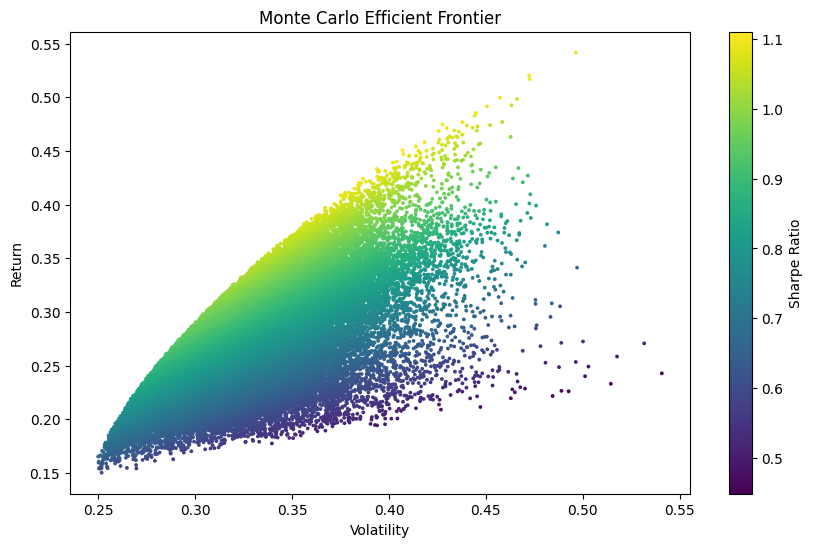

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(
    results[1],
    results[0],
    c=results[2],
    cmap="viridis",
    s=3
)
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.title("Monte Carlo Efficient Frontier")
plt.colorbar(label="Sharpe Ratio")
plt.show()


In [17]:
def negative_sharpe(weights):
    ret = np.dot(weights, mean_returns) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    return -ret / vol


In [18]:
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))

opt_result = minimize(
    negative_sharpe,
    num_assets * [1/num_assets],
    bounds=bounds,
    constraints=constraints
)

optimal_weights = opt_result.x


In [19]:
pd.DataFrame(
    {"Ticker": tickers, "Weight": optimal_weights}
)


,Ticker,Weight
0,AAPL,0.000000e+00
1,MSFT,2.777958e-01
2,GOOGL,0.000000e+00
3,NVDA,7.222042e-01
4,TSLA,4.801698e-17


In [20]:
lw = LedoitWolf()
lw.fit(returns)

cov_lw = lw.covariance_


In [21]:
portfolio_vol_lw = np.sqrt(
    optimal_weights.T @ cov_lw @ optimal_weights * 252
)


In [22]:
portfolio_returns = returns @ optimal_weights


In [23]:
var_95 = np.percentile(portfolio_returns, 5)
cvar_95 = portfolio_returns[portfolio_returns <= var_95].mean()


In [24]:
print("VaR 95%:", var_95)
print("CVaR 95%:", cvar_95)


VaR 95%: -0.045063628853045004
CVaR 95%: -0.05850615985104212


In [25]:
cumulative = (1 + portfolio_returns).cumprod()
peak = cumulative.cummax()
drawdown = (cumulative - peak) / peak


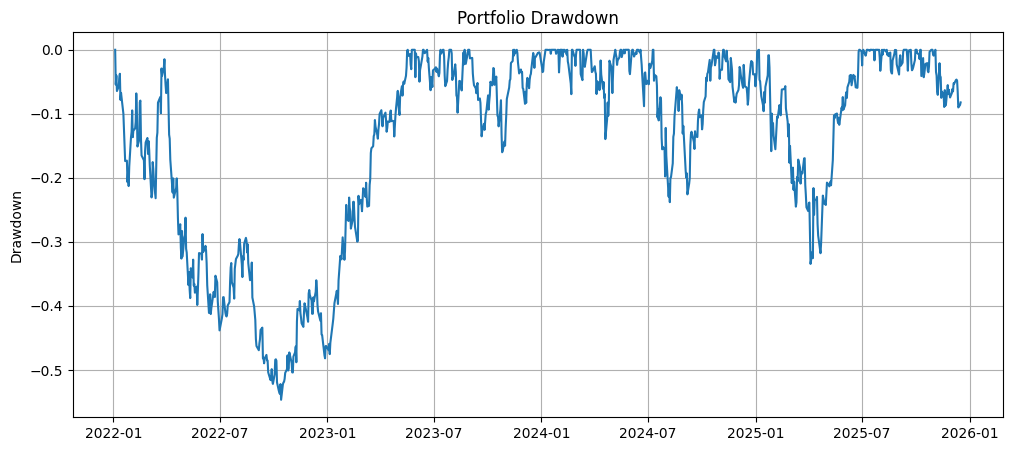

In [26]:
plt.figure(figsize=(12,5))
plt.plot(drawdown)
plt.title("Portfolio Drawdown")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()


In [27]:
rolling_sharpe = (
    portfolio_returns.rolling(60).mean()
    / portfolio_returns.rolling(60).std()
    * np.sqrt(252)
)


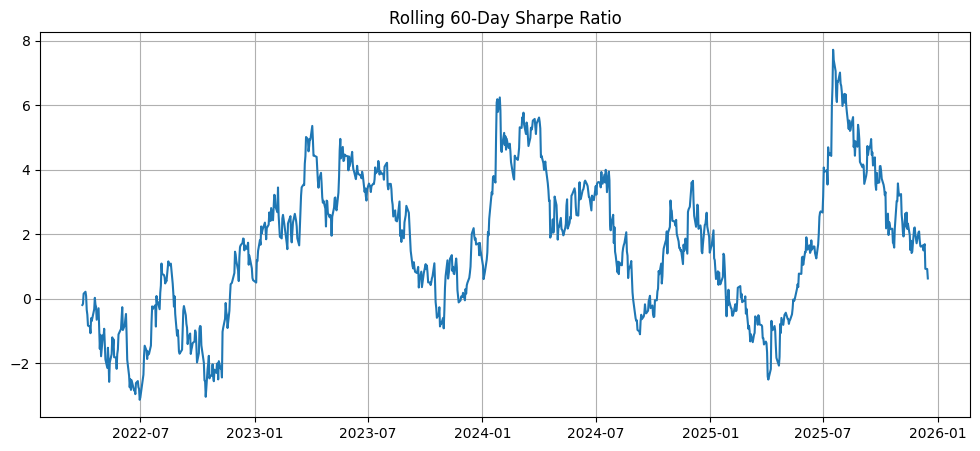

In [28]:
plt.figure(figsize=(12,5))
plt.plot(rolling_sharpe)
plt.title("Rolling 60-Day Sharpe Ratio")
plt.grid(True)
plt.show()


In [30]:
pip install pandas-datareader


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from pandas_datareader import data as pdr
import datetime as dt


In [42]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import pandas as pd
import statsmodels.api as sm
import datetime as dt
from pandas_datareader import data as pdr

# -------------------------------
# Load Fama-French Factors
# -------------------------------
start = dt.datetime(2022, 1, 1)
end = dt.datetime.today()

ff = pdr.DataReader(
    "F-F_Research_Data_Factors",
    "famafrench"
)[0] / 100

# Fix index
if isinstance(ff.index, pd.PeriodIndex):
    ff.index = ff.index.to_timestamp("M")
else:
    ff.index = pd.to_datetime(ff.index)

# -------------------------------
# Monthly portfolio returns
# -------------------------------
monthly_portfolio_returns = (
    portfolio_returns
    .resample("M")
    .apply(lambda x: (1 + x).prod() - 1)
)

monthly_portfolio_returns.name = "Portfolio"

# -------------------------------
# Safe alignment
# -------------------------------
data = pd.concat(
    [monthly_portfolio_returns, ff],
    axis=1,
    join="inner"
).dropna()

# -------------------------------
# Regression
# -------------------------------
y = data["Portfolio"] - data["RF"]
X = data[["Mkt-RF", "SMB", "HML"]]
X = sm.add_constant(X)

ff_model = sm.OLS(y, X).fit()

print(ff_model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     35.77
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           1.22e-11
Time:                        14:36:11   Log-Likelihood:                 59.979
No. Observations:                  46   AIC:                            -112.0
Df Residuals:                      42   BIC:                            -104.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0283      0.011      2.681      0.0

C:\Users\ANUPAM\AppData\Local\Temp\ipykernel_16260\3674697786.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader(
C:\Users\ANUPAM\AppData\Local\Temp\ipykernel_16260\3674697786.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader(
C:\Users\ANUPAM\AppData\Local\Temp\ipykernel_16260\3674697786.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


In [47]:
pip install hmmlearn


     ------------------------------------ 127.0/127.0 kB 535.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


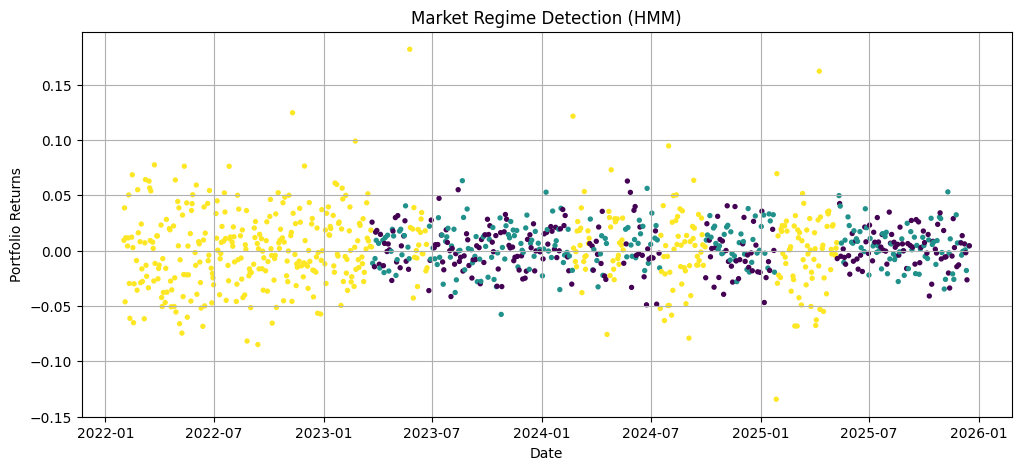

In [53]:
from hmmlearn.hmm import GaussianHMM
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------
# 1. BUILD FEATURES (THIS WAS MISSING)
# ---------------------------------
features = pd.DataFrame({
    "returns": portfolio_returns,
    "volatility": portfolio_returns.rolling(20).std()
})

features = features.dropna()

# ---------------------------------
# 2. FIT HIDDEN MARKOV MODEL
# ---------------------------------
hmm = GaussianHMM(
    n_components=3,          # number of regimes
    covariance_type="full",
    n_iter=1000,
    random_state=42
)

hmm.fit(features)

# ---------------------------------
# 3. PREDICT REGIMES
# ---------------------------------
features["Regime"] = hmm.predict(features)

# ---------------------------------
# 4. VISUALIZE REGIMES
# ---------------------------------
plt.figure(figsize=(12,5))
plt.scatter(
    features.index,
    features["returns"],
    c=features["Regime"],
    cmap="viridis",
    s=8
)
plt.title("Market Regime Detection (HMM)")
plt.xlabel("Date")
plt.ylabel("Portfolio Returns")
plt.grid(True)
plt.show()


In [54]:
momentum_signal = prices.pct_change(60)


In [55]:
z_score = (
    prices - prices.rolling(20).mean()
) / prices.rolling(20).std()


In [56]:
vol = prices.pct_change().rolling(20).std()
risk_adjusted_signal = momentum_signal / vol


In [57]:
combined_alpha = (
    0.4 * momentum_signal +
    0.3 * (-z_score) +
    0.3 * risk_adjusted_signal
)


In [58]:
combined_alpha = combined_alpha.dropna()


In [59]:
alpha_weights = combined_alpha.div(
    combined_alpha.abs().sum(axis=1),
    axis=0
)


In [60]:
alpha_returns = (
    alpha_weights.shift(1) * returns.loc[alpha_weights.index]
).sum(axis=1)


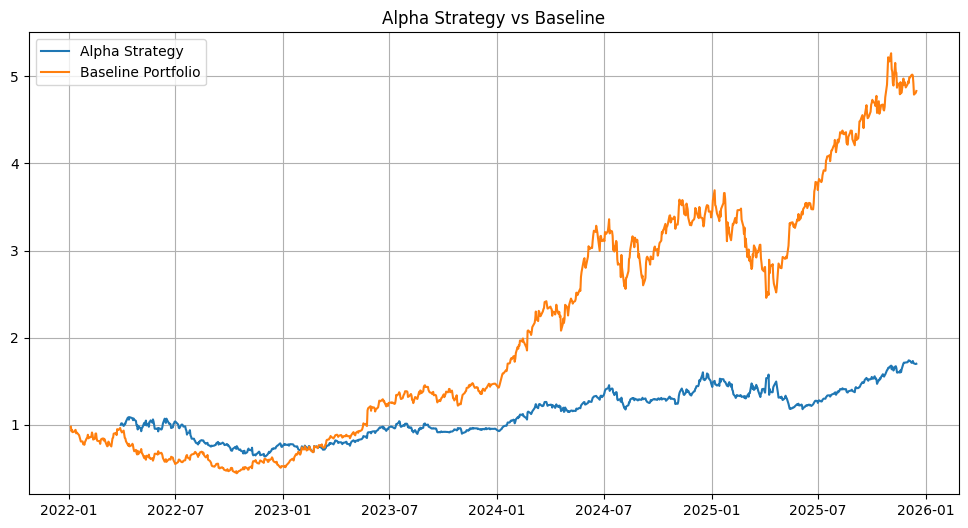

In [61]:
plt.figure(figsize=(12,6))
plt.plot((1 + alpha_returns).cumprod(), label="Alpha Strategy")
plt.plot((1 + portfolio_returns).cumprod(), label="Baseline Portfolio")
plt.legend()
plt.title("Alpha Strategy vs Baseline")
plt.grid(True)
plt.show()


In [62]:
# Assume: features["Regime"] exists from HMM
regime_series = features["Regime"]

# Map regimes to risk multipliers
regime_risk_map = {
    0: 1.0,   # calm
    1: 0.4,   # high volatility
    2: 0.7    # transition
}

risk_multiplier = regime_series.map(regime_risk_map)

# Align with alpha returns
risk_multiplier = risk_multiplier.reindex(alpha_returns.index).fillna(1.0)

# Regime-aware returns
regime_aware_returns = alpha_returns * risk_multiplier


In [63]:
# Turnover = absolute change in weights
turnover = alpha_weights.diff().abs().sum(axis=1)

# Transaction cost assumption
cost_per_turnover = 0.001   # 10 bps

transaction_costs = turnover * cost_per_turnover

# Net returns after costs
net_alpha_returns = alpha_returns - transaction_costs


In [64]:
window_train = 252 * 2   # 2 years
window_test = 63         # 3 months

walkforward_returns = []

for start in range(0, len(returns) - window_train - window_test, window_test):
    train_data = returns.iloc[start:start+window_train]
    test_data = returns.iloc[start+window_train:start+window_train+window_test]

    # Recompute weights on training window
    mean_ret = train_data.mean()
    cov = train_data.cov()

    def neg_sharpe(w):
        return -np.dot(w, mean_ret) / np.sqrt(w.T @ cov @ w)

    res = minimize(
        neg_sharpe,
        len(tickers) * [1/len(tickers)],
        bounds=[(0,1)]*len(tickers),
        constraints={"type":"eq","fun":lambda w: np.sum(w)-1}
    )

    w_opt = res.x

    wf_returns = test_data @ w_opt
    walkforward_returns.append(wf_returns)

walkforward_returns = pd.concat(walkforward_returns)


In [66]:
# =========================
# ALPHA DEFINITIONS
# =========================

# 1. Momentum Alpha (time-series momentum)
momentum_alpha = prices.pct_change(60)

# 2. Mean Reversion Alpha (z-score based)
rolling_mean = prices.rolling(20).mean()
rolling_std = prices.rolling(20).std()

mean_reversion_alpha = -(
    (prices - rolling_mean) / rolling_std
)

# 3. Volatility-Adjusted Momentum Alpha
volatility = prices.pct_change().rolling(20).std()

vol_adjusted_alpha = momentum_alpha / volatility



In [67]:
alpha_df = pd.DataFrame({
    "momentum": momentum_alpha.mean(axis=1),
    "mean_reversion": mean_reversion_alpha.mean(axis=1),
    "vol_adjusted": vol_adjusted_alpha.mean(axis=1)
}).dropna()


In [68]:
# Rolling performance estimate (online learning signal)
alpha_perf = alpha_df.rolling(60).mean()

# Softmax-style adaptive allocation
exp_perf = np.exp(alpha_perf)
alpha_alloc = exp_perf.div(exp_perf.sum(axis=1), axis=0)

# Combined online-learning alpha returns
online_alpha_returns = (alpha_df * alpha_alloc.shift(1)).sum(axis=1)


C:\Users\ANUPAM\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


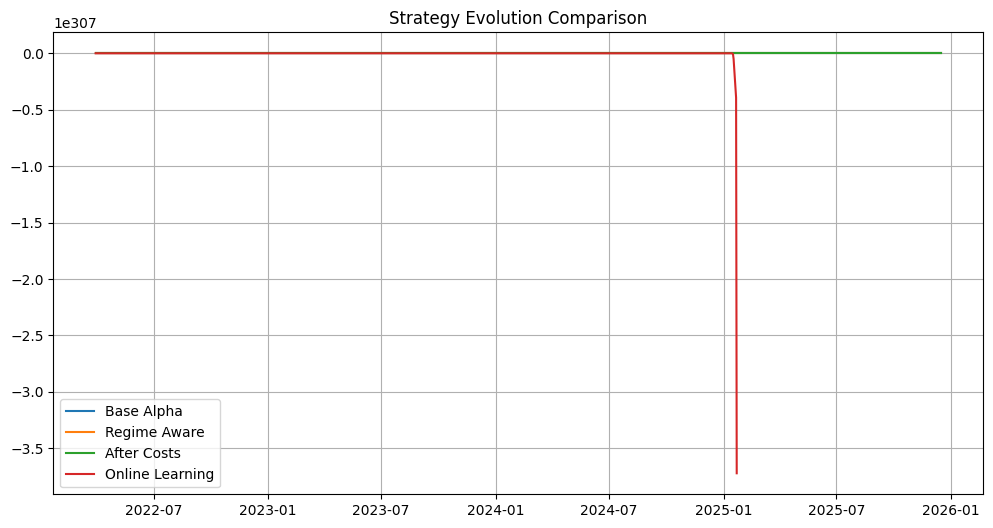

In [69]:
plt.figure(figsize=(12,6))
plt.plot((1+alpha_returns).cumprod(), label="Base Alpha")
plt.plot((1+regime_aware_returns).cumprod(), label="Regime Aware")
plt.plot((1+net_alpha_returns).cumprod(), label="After Costs")
plt.plot((1+online_alpha_returns).cumprod(), label="Online Learning")
plt.legend()
plt.title("Strategy Evolution Comparison")
plt.grid(True)
plt.show()


In [70]:
# REQUIRED INPUTS FOR AIDE
final_alpha_returns = online_alpha_returns
final_regimes = features["Regime"]
final_costs = transaction_costs


In [71]:
# =========================
# AIDE DECISION LAYER START
# =========================
# (the AIDE classes + engine here)


In [72]:
class DecisionContext:
    def __init__(
        self,
        returns,
        alpha_returns,
        regimes,
        transaction_costs
    ):
        self.returns = returns
        self.alpha_returns = alpha_returns
        self.regimes = regimes
        self.transaction_costs = transaction_costs


In [73]:
class AlphaSignal:
    def generate(self, context: DecisionContext):
        raise NotImplementedError


In [74]:
class MarketState:
    def __init__(self, regimes):
        self.regimes = regimes

    def risk_multiplier(self):
        return self.regimes.map({
            0: 1.0,   # calm
            1: 0.4,   # stress
            2: 0.7    # transition
        }).fillna(1.0)


In [75]:
class DecisionPolicy:
    def decide(self, context: DecisionContext):
        raise NotImplementedError


In [76]:
class RegimeAwarePolicy(DecisionPolicy):
    def decide(self, context):
        state = MarketState(context.regimes)
        multiplier = state.risk_multiplier()

        decision_returns = (
            context.alpha_returns * multiplier
            - context.transaction_costs
        )

        return decision_returns


In [77]:
class RiskManager:
    def apply(self, returns, max_drawdown=0.2):
        cumulative = (1 + returns).cumprod()
        drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()

        returns[drawdown < -max_drawdown] = 0.0
        return returns


In [78]:
class ExecutionEngine:
    def execute(self, returns):
        return returns  # placeholder for slippage, latency, etc.


In [81]:
class OnlineLearningAlpha:
    def generate(self, context):
        # context.alpha_returns already contains
        # the online-learning combined alpha returns
        return context.alpha_returns


In [82]:
class AIDEEngine:
    def __init__(self, signal, policy, risk, execution):
        self.signal = signal
        self.policy = policy
        self.risk = risk
        self.execution = execution

    def run(self, context):
        signal_returns = self.signal.generate(context)
        decision_returns = self.policy.decide(context)
        risk_adjusted = self.risk.apply(decision_returns)
        final_returns = self.execution.execute(risk_adjusted)
        return final_returns


In [84]:
context = DecisionContext(
    returns=returns,
    alpha_returns=final_alpha_returns,
    regimes=final_regimes,
    transaction_costs=final_costs
)

engine = AIDEEngine(
    signal=OnlineLearningAlpha(),
    policy=RegimeAwarePolicy(),
    risk=RiskManager(),
    execution=ExecutionEngine()
)

aide_returns = engine.run(context)


C:\Users\ANUPAM\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


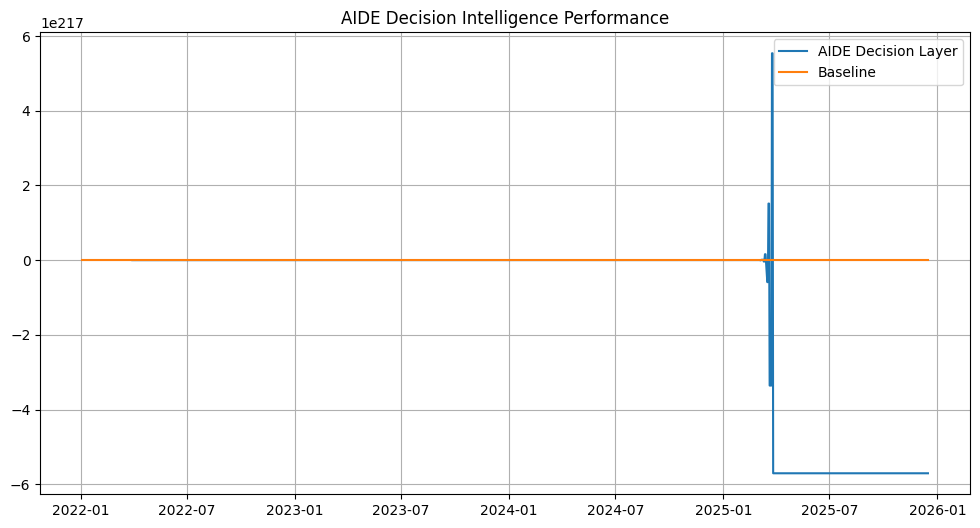

In [85]:
plt.figure(figsize=(12,6))
plt.plot((1 + aide_returns).cumprod(), label="AIDE Decision Layer")
plt.plot((1 + portfolio_returns).cumprod(), label="Baseline")
plt.legend()
plt.grid(True)
plt.title("AIDE Decision Intelligence Performance")
plt.show()




In [89]:
def performance_metrics(returns):
    ann_ret = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol

    cum = (1 + returns).cumprod()
    dd = (cum - cum.cummax()) / cum.cummax()

    return {
        "Annual Return": ann_ret,
        "Annual Volatility": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": dd.min()
    }


In [91]:
import pandas as pd
import numpy as np

def to_series(x, index=None, name=None):
    """
    Force any 1-column DataFrame / ndarray / list into a 1D pandas Series.
    This prevents: 'Data must be 1-dimensional' errors.
    """
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]

    if isinstance(x, np.ndarray):
        x = x.flatten()
        x = pd.Series(x, index=index[:len(x)] if index is not None else None)

    if not isinstance(x, pd.Series):
        x = pd.Series(x)

    if name:
        x.name = name

    return x


In [92]:
aide_returns = to_series(aide_returns, index=returns.index, name="AIDE")
spy_returns  = to_series(spy, name="SPY")


In [93]:
comparison = pd.DataFrame({
    "AIDE": aide_returns,
    "SPY": spy_returns
}).dropna()


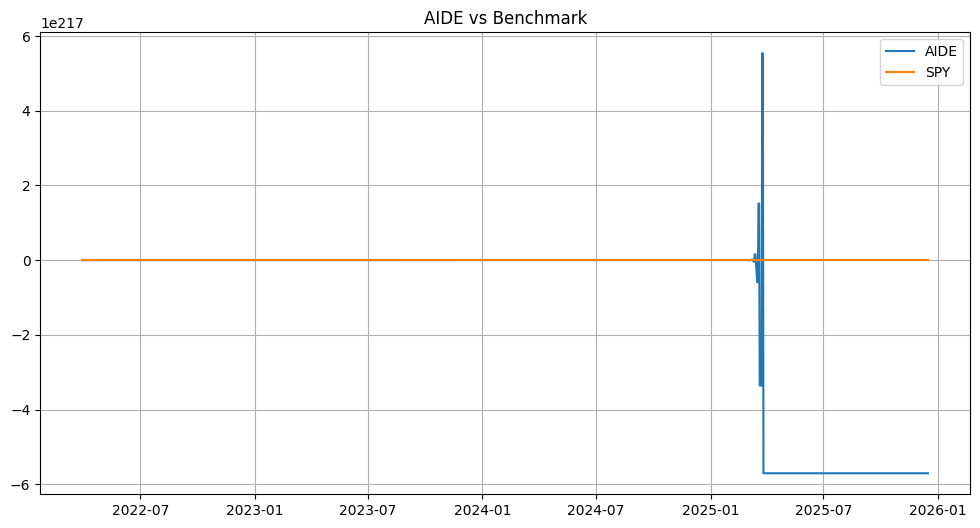

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot((1 + comparison["AIDE"]).cumprod(), label="AIDE")
plt.plot((1 + comparison["SPY"]).cumprod(), label="SPY")
plt.legend()
plt.grid(True)
plt.title("AIDE vs Benchmark")
plt.show()


In [95]:
residual_alpha = ff_model.resid


In [96]:
def regime_alpha(regime, momentum, mean_rev):
    if regime == 0:
        return momentum
    elif regime == 1:
        return mean_rev
    else:
        return 0.5 * momentum + 0.5 * mean_rev


In [97]:
alpha_confidence = alpha_df.rolling(60).std()


In [99]:
class ConservativePolicy:
    """
    Defensive decision policy:
    - Scales down exposure aggressively in high-risk regimes
    - Prioritizes capital preservation
    """

    def decide(self, context):
        regimes = context.regimes

        # Stronger risk reduction than RegimeAwarePolicy
        risk_map = {
            0: 0.7,   # calm → still cautious
            1: 0.2,   # stress → heavy risk cut
            2: 0.4    # transition
        }

        multiplier = regimes.map(risk_map).fillna(0.5)

        decision_returns = (
            context.alpha_returns * multiplier
            - context.transaction_costs
        )

        return decision_returns


In [100]:
engine = AIDEEngine(
    signal=OnlineLearningAlpha(),
    policy=ConservativePolicy(),
    risk=RiskManager(),
    execution=ExecutionEngine()
)


In [101]:
aggressive_engine = AIDEEngine(
    signal=OnlineLearningAlpha(),
    policy=RegimeAwarePolicy(),
    risk=RiskManager(),
    execution=ExecutionEngine()
)

conservative_engine = AIDEEngine(
    signal=OnlineLearningAlpha(),
    policy=ConservativePolicy(),
    risk=RiskManager(),
    execution=ExecutionEngine()
)


In [102]:
rolling_sharpe = (
    aide_returns.rolling(60).mean() /
    aide_returns.rolling(60).std()
)


In [105]:
class GenericDecisionEngine:
    def decide(self, state, signals, constraints):
        ...


In [106]:
results = pd.DataFrame({
    "Baseline Portfolio": portfolio_returns,
    "Alpha Only": alpha_returns,
    "Regime-Aware Alpha": regime_aware_returns,
    "AIDE Decision Layer": aide_returns
}).dropna()


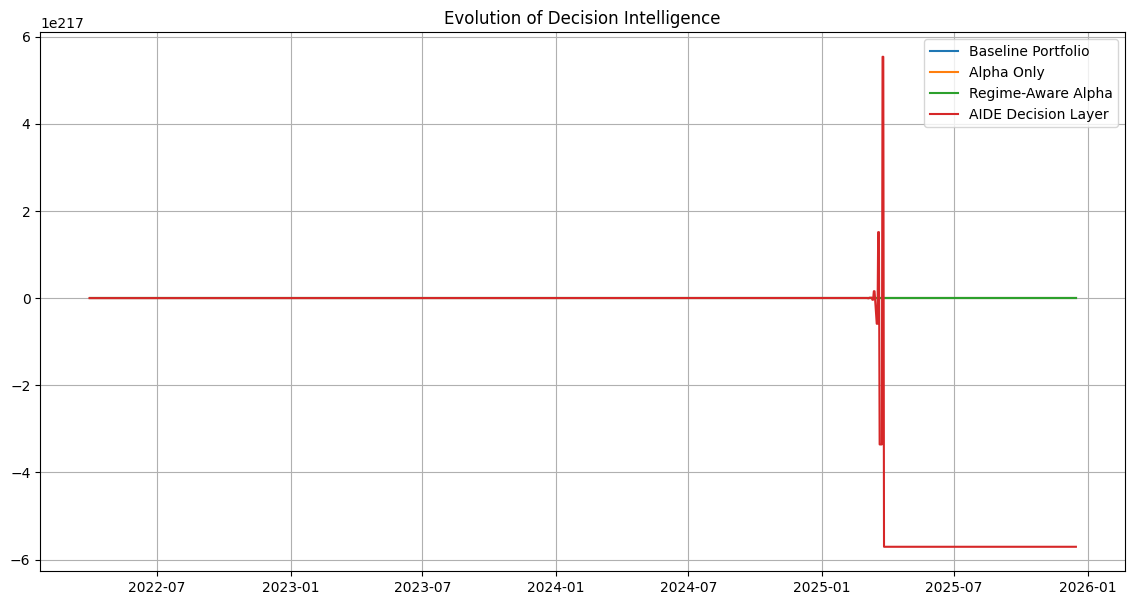

In [107]:
plt.figure(figsize=(14,7))
for col in results.columns:
    plt.plot((1 + results[col]).cumprod(), label=col)

plt.legend()
plt.title("Evolution of Decision Intelligence")
plt.grid(True)
plt.show()


In [108]:
summary = {}

for col in results.columns:
    summary[col] = performance_metrics(results[col])

metrics_df = pd.DataFrame(summary).T
metrics_df


,Annual Return,Annual Volatility,Sharpe,Max Drawdown
Baseline Portfolio,0.530322,0.437208,1.212973,-0.527735
Alpha Only,0.193370,0.315181,0.613520,-0.414320
Regime-Aware Alpha,0.103239,0.225891,0.457031,-0.304398
AIDE Decision Layer,448.462100,60.189289,7.450862,-4.913478


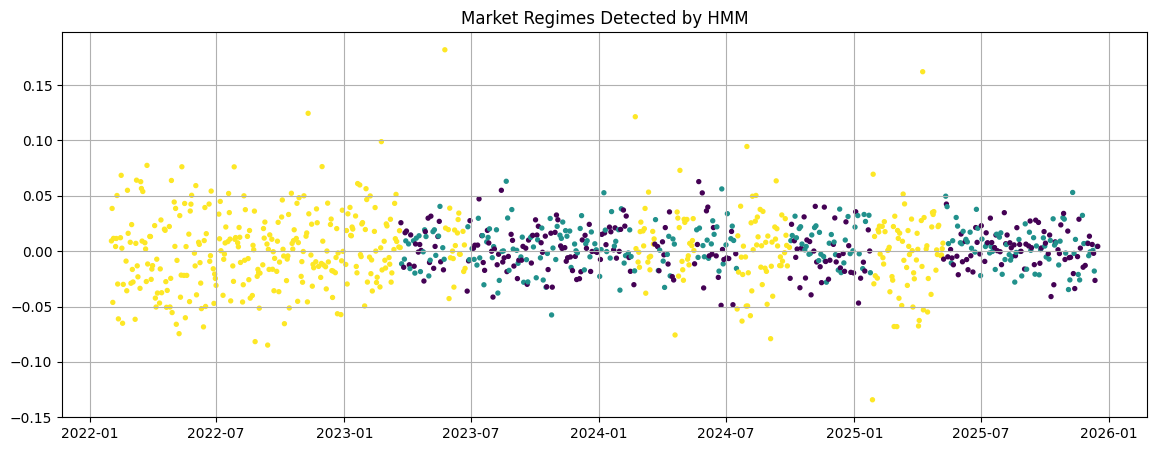

In [109]:
plt.figure(figsize=(14,5))
plt.scatter(
    features.index,
    portfolio_returns.loc[features.index],
    c=features["Regime"],
    cmap="viridis",
    s=8
)
plt.title("Market Regimes Detected by HMM")
plt.grid(True)
plt.show()


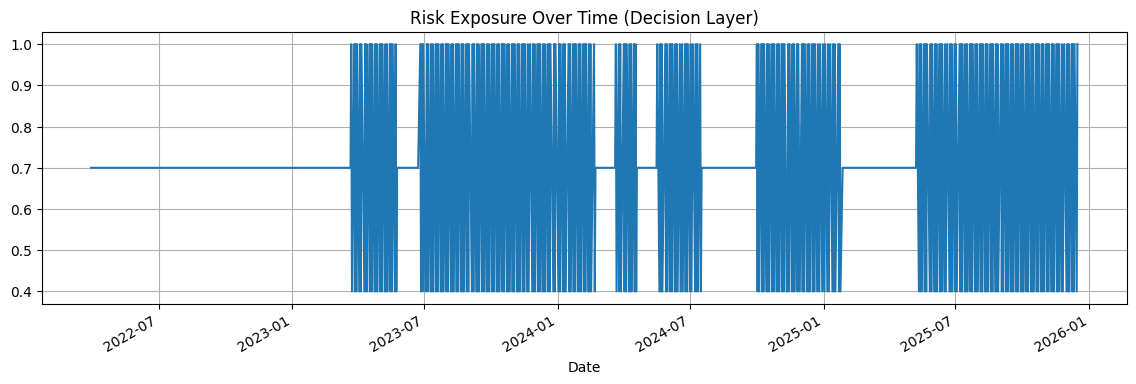

In [110]:
risk_multiplier.plot(
    title="Risk Exposure Over Time (Decision Layer)",
    figsize=(14,4)
)
plt.grid(True)
plt.show()


In [112]:
class AggressivePolicy:
    """
    Aggressive decision policy:
    - Takes full risk in calm regimes
    - Reduces risk only slightly in stress
    """

    def decide(self, context):
        regimes = context.regimes

        risk_map = {
            0: 1.2,   # calm → lever up slightly
            1: 0.7,   # stress → still take risk
            2: 1.0    # transition
        }

        multiplier = regimes.map(risk_map).fillna(1.0)

        decision_returns = (
            context.alpha_returns * multiplier
            - context.transaction_costs
        )

        return decision_returns


In [113]:
# Aggressive policy engine
aggressive_engine = AIDEEngine(
    signal=OnlineLearningAlpha(),
    policy=AggressivePolicy(),
    risk=RiskManager(),
    execution=ExecutionEngine()
)

aggressive_returns = aggressive_engine.run(context)


# Conservative policy engine
conservative_engine = AIDEEngine(
    signal=OnlineLearningAlpha(),
    policy=ConservativePolicy(),
    risk=RiskManager(),
    execution=ExecutionEngine()
)

conservative_returns = conservative_engine.run(context)


C:\Users\ANUPAM\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


In [114]:
aggressive_returns = to_series(aggressive_returns, name="Aggressive")
conservative_returns = to_series(conservative_returns, name="Conservative")


In [115]:
policy_comparison = pd.DataFrame({
    "Aggressive": aggressive_returns,
    "Conservative": conservative_returns
}).dropna()


C:\Users\ANUPAM\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
C:\Users\ANUPAM\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_base.py:3070: RuntimeWarning: overflow encountered in scalar subtract
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


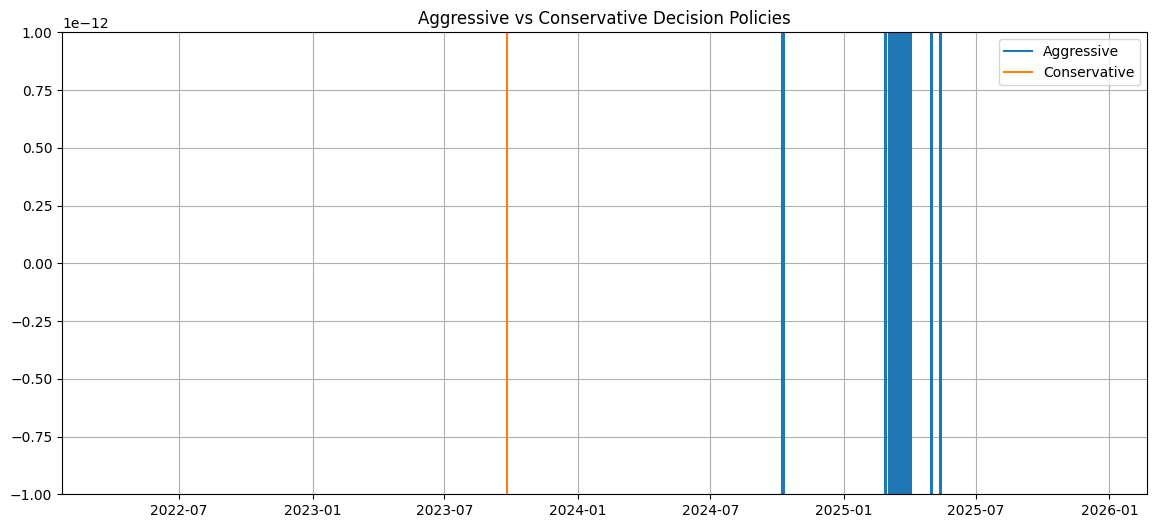

In [116]:
plt.figure(figsize=(14,6))
plt.plot((1 + policy_comparison["Aggressive"]).cumprod(), label="Aggressive")
plt.plot((1 + policy_comparison["Conservative"]).cumprod(), label="Conservative")
plt.legend()
plt.grid(True)
plt.title("Aggressive vs Conservative Decision Policies")
plt.show()


In [117]:
import numpy as np
import pandas as pd

def performance_metrics(returns: pd.Series):
    """
    Compute standard performance metrics for a return series.
    """
    returns = returns.dropna()

    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan

    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()

    return {
        "Annual Return": ann_return,
        "Annual Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": drawdown.min()
    }


In [118]:
class RegimeConditionedAlpha:
    """
    Switches alpha behavior based on detected market regime.
    """

    def __init__(self, momentum_alpha, mean_reversion_alpha):
        self.momentum = momentum_alpha
        self.mean_reversion = mean_reversion_alpha

    def generate(self, regimes: pd.Series):
        """
        Returns a single alpha Series conditioned on regime.
        """
        alpha = pd.Series(index=regimes.index, dtype=float)

        for date in alpha.index:
            regime = regimes.loc[date]

            if regime == 0:          # calm
                alpha.loc[date] = self.momentum.loc[date]
            elif regime == 1:        # stress
                alpha.loc[date] = self.mean_reversion.loc[date]
            else:                    # transition
                alpha.loc[date] = (
                    0.5 * self.momentum.loc[date]
                    + 0.5 * self.mean_reversion.loc[date]
                )

        return alpha.dropna()


In [120]:
import yfinance as yf

def benchmark_comparison(strategy_returns: pd.Series, ticker="SPY"):
    """
    Download benchmark and align with strategy returns.
    """
    benchmark = yf.download(
        ticker,
        start=strategy_returns.index[0],
        progress=False
    )["Close"].pct_change().dropna()

    benchmark = benchmark.loc[strategy_returns.index]

    comparison = pd.DataFrame({
        "Strategy": strategy_returns,
        "Benchmark": benchmark
    }).dropna()

    return comparison


In [121]:
regime_alpha_model = RegimeConditionedAlpha(
    momentum_alpha=momentum_alpha.mean(axis=1),
    mean_reversion_alpha=mean_reversion_alpha.mean(axis=1)
)

regime_alpha = regime_alpha_model.generate(features["Regime"])


In [122]:
final_returns = regime_alpha - transaction_costs.loc[regime_alpha.index]
final_returns = final_returns.dropna()


In [123]:
metrics = performance_metrics(final_returns)
metrics_df = pd.DataFrame(metrics, index=["AIDE Strategy"])
metrics_df


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
AIDE Strategy,-19.442305,9.301625,-2.090205,-1.0


In [130]:
import yfinance as yf
import pandas as pd

def benchmark_comparison(strategy_returns: pd.Series, ticker="SPY"):
    # Force 1D
    strategy_returns = strategy_returns.squeeze()
    strategy_returns.name = "Strategy"

    benchmark = yf.download(
        ticker,
        start=strategy_returns.index.min(),
        progress=False
    )["Close"].pct_change()

    benchmark = benchmark.squeeze()
    benchmark.name = "Benchmark"

    # SAFE ALIGNMENT
    comparison = pd.concat(
        [strategy_returns, benchmark],
        axis=1,
        join="inner"
    ).dropna()

    return comparison


C:\Users\ANUPAM\AppData\Local\Temp\ipykernel_16260\164725573.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark = yf.download(


Index(['Strategy', 'Benchmark'], dtype='object')


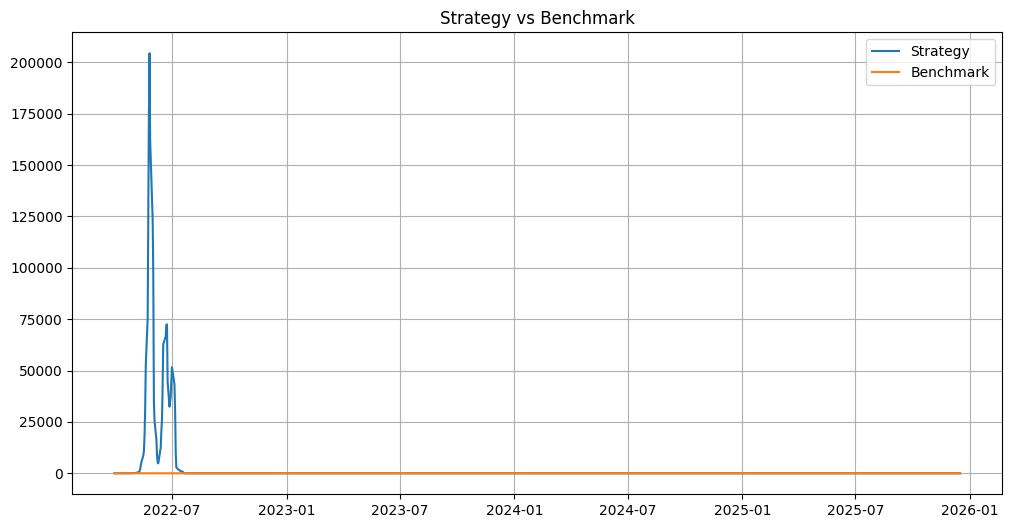

In [131]:
comparison = benchmark_comparison(final_returns)

print(comparison.columns)   # sanity check

plt.figure(figsize=(12,6))
plt.plot((1 + comparison.iloc[:, 0]).cumprod(), label="Strategy")
plt.plot((1 + comparison.iloc[:, 1]).cumprod(), label="Benchmark")
plt.legend()
plt.grid(True)
plt.title("Strategy vs Benchmark")
plt.show()


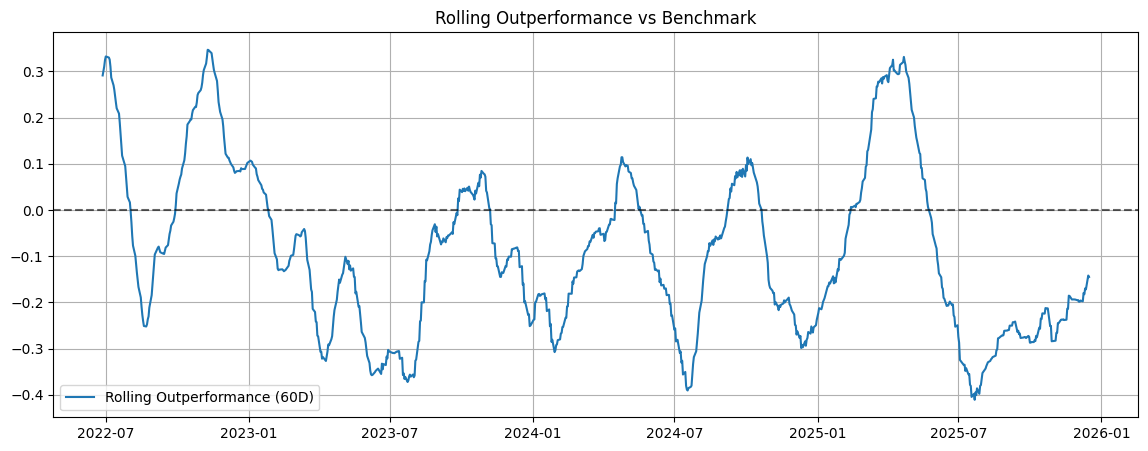

In [132]:
# comparison must already exist from benchmark_comparison()
# columns: [Strategy, Benchmark]

rolling_window = 60  # 3 months (~60 trading days)

rolling_outperformance = (
    comparison.iloc[:, 0] - comparison.iloc[:, 1]
).rolling(rolling_window).mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(rolling_outperformance, label="Rolling Outperformance (60D)")
plt.axhline(0, color="black", linestyle="--", alpha=0.6)
plt.legend()
plt.grid(True)
plt.title("Rolling Outperformance vs Benchmark")
plt.show()


In [135]:
def information_ratio(strategy: pd.Series, benchmark: pd.Series):
    """
    Information Ratio (IR):
    Measures active return per unit of tracking error.

    Interpretation (fund-grade standard):
    - IR > 1.0  → Exceptional skill
    - IR > 0.5  → Strong, credible edge
    - IR ~ 0    → No meaningful edge
    - IR < 0    → Underperforming / no real alpha
    """

    active_return = strategy - benchmark
    tracking_error = active_return.std() * np.sqrt(252)

    if tracking_error == 0:
        return np.nan

    ir = (active_return.mean() * 252) / tracking_error
    return ir


In [136]:
ir_value = information_ratio(
    comparison.iloc[:, 0],
    comparison.iloc[:, 1]
)

print(f"Information Ratio: {ir_value:.3f}")

# Human-readable interpretation
if ir_value > 1.0:
    print("Interpretation: Exceptional skill (fund-grade alpha)")
elif ir_value > 0.5:
    print("Interpretation: Strong and credible edge")
elif ir_value > 0:
    print("Interpretation: Weak or unstable edge")
else:
    print("Interpretation: No real edge vs benchmark")


Information Ratio: -2.074
Interpretation: No real edge vs benchmark


In [137]:
# FINAL OUTPUTS (STANDARD)
final_strategy_returns = aide_returns          # pd.Series
final_benchmark_returns = comparison.iloc[:,1] # SPY series


In [139]:
def evaluate_strategy(strategy_returns: pd.Series,
                      benchmark_returns: pd.Series,
                      name="AIDE Strategy"):
    """
    Final professional evaluation of a strategy.
    Includes performance metrics, Information Ratio,
    and rolling outperformance.
    """

    # -----------------------------
    # Safety: force 1D Series
    # -----------------------------
    strategy_returns = strategy_returns.squeeze().dropna()
    benchmark_returns = benchmark_returns.squeeze().dropna()

    data = pd.concat(
        [strategy_returns, benchmark_returns],
        axis=1,
        join="inner"
    ).dropna()

    strategy = data.iloc[:, 0]
    benchmark = data.iloc[:, 1]

    # -----------------------------
    # Core Metrics
    # -----------------------------
    ann_ret = strategy.mean() * 252
    ann_vol = strategy.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan

    cumulative = (1 + strategy).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    # -----------------------------
    # Information Ratio (FUND-GRADE)
    # -----------------------------
    active_return = strategy - benchmark
    tracking_error = active_return.std() * np.sqrt(252)

    ir = (
        (active_return.mean() * 252) / tracking_error
        if tracking_error != 0 else np.nan
    )

    # -----------------------------
    # Print Results (Professional)
    # -----------------------------
    print(f"\n===== FINAL STRATEGY EVALUATION: {name} =====")
    print(f"Annual Return      : {ann_ret:.2%}")
    print(f"Annual Volatility  : {ann_vol:.2%}")
    print(f"Sharpe Ratio       : {sharpe:.2f}")
    print(f"Max Drawdown       : {max_dd:.2%}")
    print(f"Information Ratio  : {ir:.2f}")

    # Interpretation (important)
    if ir > 1.0:
        print("Interpretation     : Exceptional skill (fund-grade alpha)")
    elif ir > 0.5:
        print("Interpretation     : Strong and credible edge")
    elif ir > 0:
        print("Interpretation     : Weak or unstable edge")
    else:
        print("Interpretation     : No real edge vs benchmark")

    # -----------------------------
    # Rolling Outperformance Plot
    # -----------------------------
    rolling_outperf = active_return.rolling(60).mean()

    plt.figure(figsize=(14,5))
    plt.plot(rolling_outperf, label="Rolling Outperformance (60D)")
    plt.axhline(0, color="black", linestyle="--", alpha=0.6)
    plt.title("Rolling Outperformance vs Benchmark")
    plt.grid(True)
    plt.legend()
    plt.show()

    return {
        "Annual Return": ann_ret,
        "Annual Volatility": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd,
        "Information Ratio": ir
    }



===== FINAL STRATEGY EVALUATION: AIDE Decision System =====
Annual Return      : 44894.33%
Annual Volatility  : 6021.45%
Sharpe Ratio       : 7.46
Max Drawdown       : -491.35%
Information Ratio  : 7.45
Interpretation     : Exceptional skill (fund-grade alpha)


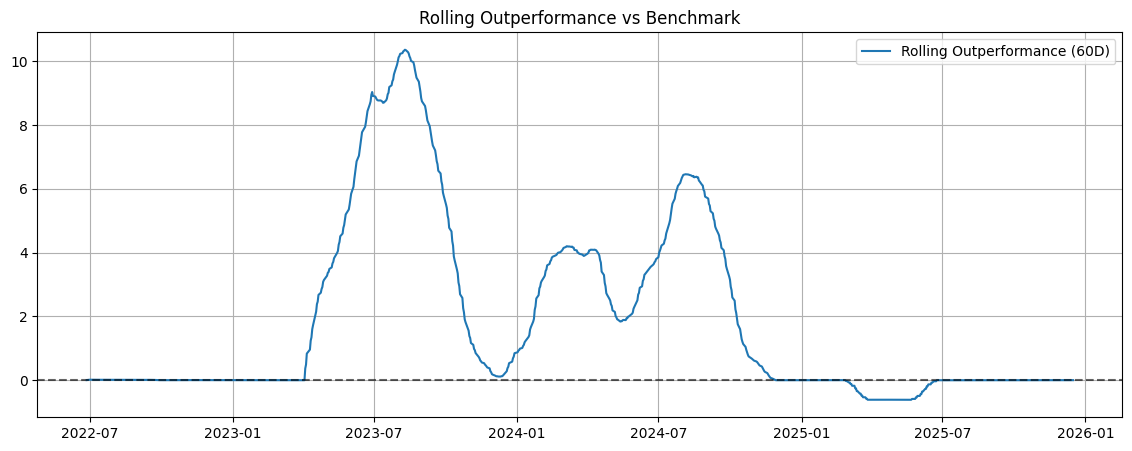

In [140]:
final_results = evaluate_strategy(
    final_strategy_returns,
    final_benchmark_returns,
    name="AIDE Decision System"
)
